# 5. Segregation Indexes

Following the Bojanowski & Corten Paper _Measuring Segregation in Social Networks_ 2014, We calculate some segregation indexes for our graphs along the time. First, we import the data and libraries ised for the creation of the functions in the Prerequiste section. Then We calculate The Freeman Segregation Index and the Spectral Segregatoin Index in The next Sections. This Notebook is divided en the following sections.

1. Prerequisites
2. 3 Day Rolling Window
    -  Freeman Segregation Index
    - Spectral Segregation Index
3. Daily
4. Conclusion 


## 1. Prerequistes

In [1]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import pickle
from glob import glob
from tqdm import tqdm
import random

For the calculation of the segregation Indexes, we define some notation based on (Bojanowski & Corten 2014).

We define a Graph with

$$\mathbb{N}= \{1, \dots, i, \dots, N\}$$

and then, define the set

$$\mathbb{G} = \{G_1, G_2,\dots, G_k\}$$

as the set of $K$ groups in which every $G_g$ is a subset of $\mathbb{N}$ that contains all the nodes that belong to group $g$. 

Now we define the type vector as 

$$\textbf{t} = [t_1,\dots, t_i, \dots, t_N]$$

where $t_i \in \{1,\dots,K\}$. This vector matches every node with its corresponding group. Using this notation. We can define a type indicator vector for each group $k$ as follows:  

$$\textbf{v}_k = [v_1, \dots, v_i, \dots, v_N]$$ 

where $v_i \in \{0,1\}$. This vector has one entry for every node and the node location will have a 1 if that node corresponds to the group $G_k$. Formally:

$$ v_i = \begin{cases} 1 &\text{ if }t_i = k \\ 0 &\text{ if }t_i \neq k \end{cases} $$

Now we define the Types Matrix $T_{N\times K}$ as a matrix that contains the information of each node and wich group it represents. For Every column of the matrix corresponds to a $\textbf{v}_k$ _types indicator vector_.

In the context of this Research, we will use a Directed Weighted Graph. Our nodes are X (formmerly Twitter) in which the user $i$ is related to the user $j$ if $i$ Retweeted a Tweet without comments of $j$. In this sense. Formarly we discribe the relationship $R$ over $\mathbb{N}\times \mathbb{N}$ that implies our square Adjcency Matrix $X = [X_{ij}]_{\mathbb{N}\times \mathbb{N}}$

In this case $x_{ij} = \dfrac{\text{\# Tweets without comments from }j\text{ that }i\text{ Retweeted}}{\text{\# of Retweets without comments from }i}$

Finally, we define the _Contact Matrix_ ($M_{gh}$) where $g$ and $h$ are two generic groups. The contact Matrix is defined as follows:

$$M_{gh1} = \sum_{i\in G_g}\sum_{j\in G_h} x_{ij}$$

Finally, in this matrix $M_{gh1}$ shows the amount of attention that group $h$ gets from group $g$

This is our toy edge list [(0, 1), (1, 2), (2, 0), (3, 1), (4, 5), (5, 4)]
This are our toy weights [8, 9, 7, 10, 12, 11]


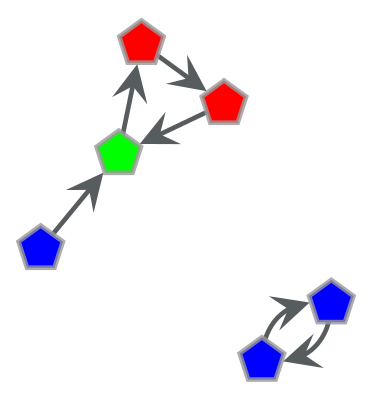

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1bc5c4ab90, at 0x7f1bc42c9450>

In [80]:
# TOY GRAPH FOR CALCULATIONS
random.seed(1)

edge_list = [(0,1),(1,2),(2,0),(3,1),(4,5),(5,4)]
vertex_dict = {
    'label': 'a b c d e f'.split(' '),
    'pa': 'd c d i i i'.split(' '),
    'id': [i for i in range(10000,10006)]
}
color = {
    'i': (0,0,1), # Azul
    'd': (1,0,0), # Rojo
    'c': (0,1,0) # Centro
}
weights = [8,9,7,10,12,11]
g = gt.Graph(directed=True)
print(f'This is our toy edge list {edge_list}')
print(f'This are our toy weights {weights}')

g.add_edge_list(edge_list=edge_list)

# Create an edge property map for weights
edge_weight_map = g.new_edge_property("double")

# Create a Vertex property map for labels
vertex_PA_map = g.new_vertex_property('string')
vertex_ID_map = g.new_vertex_property('int64_t')
vertex_color_map = g.new_vertex_property('vector<double>')
vertex_label_map = g.new_vertex_property('string')

# Add edges properties
edge_list = g.get_edges()
for i, e in enumerate(edge_list):
    edge_weight_map[e] = weights[i]

# Add Vertex properties
vertex_list = g.get_vertices()
for v in vertex_list:
    vertex_PA_map[v] = vertex_dict['pa'][v]
    vertex_ID_map[v] = vertex_dict['id'][v]
    vertex_label_map[v] = vertex_dict['label'][v]
    vertex_color_map[v] = color[vertex_dict['pa'][v]]

# Assign the maps to the Graph Object
g.vp['Political Label'] = vertex_PA_map
g.vp['User ID'] = vertex_ID_map
g.vp['Label'] = vertex_label_map
g.vp['Color'] = vertex_color_map
g.ep['Normal Weights'] = edge_weight_map

# Create a graph layout and drawing
pos = gt.sfdp_layout(g)

gt.graph_draw(g,
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')


In [128]:
def get_adjacency(g : gt.Graph, weight = None) -> np.ndarray:
    # Get EdgePropertyMap for Weights in Adjacency
    weights = g.ep[weight]

    adj = gt.adjacency(g, weight = weights).T
    return adj.toarray()

def get_types_array(g: gt.Graph, types = None, level = 0) -> np.ndarray:
    t = g.vp[types].get_2d_array([0])[level]
    return t

def get_types_dict(g: gt.Graph, types = None, level = 0) -> dict:
    # Get array of types
    t = get_types_array(g,types,level)
    T = {}
    for tipo in np.unique(t):
        row=[]
        for i in t:
            if i == tipo:
                row.append(1)
            else:
                row.append(0)        
        T[str(tipo)] = row
    return T

def get_types_index(g: gt.Graph, types = None, level = 0) -> dict:
    T = get_types_dict(g, types, level)
    Type_to_row = {k:v for v,k in enumerate(T.keys())}
    return Type_to_row

def get_types_matrix(g: gt.Graph, types = None, level = 0) -> np.ndarray:
    types_dict = get_types_dict(g,types = types,level = level)
    types_vector = types_dict.values()
    return np.array(list(types_vector)).T

def get_contact_matrix(g, types = None, level = 0, weights = None) -> np.ndarray:
    adj = get_adjacency(g, weights)
    
    types_matrix = get_types_matrix(g, types = types, level = level)
    
    M = types_matrix.T.dot(adj).dot(types_matrix)

    return M

In [180]:
file = '/mnt/disk2/Data/3_Day_Graphs/2021-05-01.graphml'
graph = gt.load_graph(file)
groups_list = get_types_dict(g,types='Political Label')['No Retweets']
g.num_vertices()
#freeman_grupos(graph,weights='Normal Weights',types='Political Label',group='No Retweets')

36964

For the Freeman Segregation Index, We will use the formula from (Bojanowski & Corten 2014) for the in which the generalize this index for $K$ groups. The index is define as Follows.

Let $p$ be equal to the proportion of _between_ group ties in the graph. This corresponds to the upper triangle of the $M$ Matrix without counting the diagonal (This diagonal contains the information of the _within_ group ties).

$$p = \frac{\sum_{g,h:g\neq h}M_{gh1}}{\sum_{g=1}^K\sum_{h=1}^K M_{gh1}}$$

Now, we define the expected proportion of between-group ties in a random graph. In the generalize case of $K$ groups. this looks like this

$$\pi = \frac{\left( \sum_{k=1}^K \eta_k\right)^2 - \sum_{k=1}^K \eta_k^2}{N(N-1)}$$

Finally, Freeman Segregation Index is defined as:

$$S_{Freeman} = 1 -\frac{p}{\pi} = 1- \frac{pN(N-1)}{\left( \sum_{k=1}^K \eta_k\right)^2 - \sum_{k=1}^K \eta_k^2}$$

In [151]:
def freeman(g: gt.Graph, types = None, weights=weights, level = 0) -> float:
    """
    Description of your function.

    Args:
        adj (Array like): The adjacency matrix of the graph for constructing the index
        
        types (Array like): Matrix of N rows (Number of Nodes) and K columns (Number of Groups) where each entry of the matrix
        specifies if that Node of row 'i' belongs to the group 'k' in column 'k'.

    Returns:
        type: Segregation Index of Freeman

    """
    # Get Relevant Matrices
    types_matrix = get_types_matrix(g, types = types)
    M = get_contact_matrix(g, types=types, weights=weights)
    
    # We get the amount of vertices and groups
    N, K = types_matrix.shape
    # Get the amount of nodes per group
    Eta_k =[]
    for k in range(K):
        Eta = np.sum(types_matrix[:, k])
        Eta_k.append(Eta)
    Eta_k = np.array(Eta_k)
    
    # Calculate In-Between edges
    M_up = np.triu(M,k=1)
    M_low = np.tril(M,k=1)
    between_edges = M_up.sum() + M_low.sum()

    # Calculate P 
    P = between_edges / M.sum()

    # Prepare for calculation
    numerator = P * N * (N - 1)
    denominator = (Eta_k.sum() **2) - (np.sum(Eta_k **2))

    # calculate using the formula
    S = 1 - (numerator / denominator)
    
    return S

In [181]:
def freeman_grupos(g: gt.Graph, types = None, group = None, weights=weights, level = 0) -> float:
    """
    Description of your function.

    Args:
        adj (Array like): The adjacency matrix of the graph for constructing the index
        
        types (Array like): Matrix of N rows (Number of Nodes) and K columns (Number of Groups) where each entry of the matrix
        specifies if that Node of row 'i' belongs to the group 'k' in column 'k'.

    Returns:
        type: Segregation Index of Freeman

    """
    if group != None:
        # get important stuff
        M = get_contact_matrix(g, types=types, weights=weights)
        groups = get_types_index(g,types)
        groups_list = get_types_dict(g,types=types)[group]
        group_index = groups[group]

        # Calculate P
        between_edges = np.sum(M[group_index])
        total_edges = np.sum(M)

        P = between_edges / total_edges
        
        # Calculate Pi
        nodes = g.num_vertices()
        nodes_in_group = np.sum(groups_list)
        nodes_out_group = nodes - nodes_in_group

        pi = nodes_out_group / nodes

        return 1 - (P / pi)
    else:
        return freeman(g,weights=weights,types=types)

In [6]:
def Spectral_Segregation_Index(adj: np.array, types: pd.DataFrame, user_indices: dict) -> float:
    """
    Description of your function.

    Args:
        adj (Array like): The adjacency matrix of the graph for constructing the index
        
        types (Array like): Matrix of N rows (Number of Nodes) and K columns (Number of Groups) where each entry of the matrix
        specifies if that Node of row 'i' belongs to the group 'k' in column 'k'.

        user_indices (Dict): a Python Dictionary in which the keys are user IDs and the values are the index of that 
        user in the adjacency matrix

    Returns:
        type: Segregation Index of Freeman

    """

    results = {}

    # Normalize adjacency
    row_sums = adj.sum(axis=1).A.ravel()
    R = adj / row_sums[:, np.newaxis]
    R = R.tocsr()

    # Get the group Indexes
    columns = list(types_df.columns)
    columns.pop(1)
    for i in columns:
        users = types_df[types_df[i] == 1].index

        # get the filter for the Adjcacency
        filter = []
        for user in users:
            filter.append(user_indices[user])
        filter

        # Get group subMatrix
        ixgrid = np.ix_(filter,filter)
        C = R[ixgrid]
        C = C.toarray()

        # Get Max EigenValue
        SSI_C = np.linalg.eig(C)
        SSI_value = max(SSI_C.eigenvalues, key = lambda x: x.real).real

        # Store Results
        results['Group'] = i
        results[i] = [SSI_value]
        
        final = pd.DataFrame(results)

    # Output
    return final

## 2. 3 Day rolling window Segregation Indexes

### 1. Freeman Segregation Index

In [ ]:
# Load Adjacency matrices
files = glob('/mnt/disk2/Data/3_Day_Graphs/*.graphml')

# Store results
data_viz = []

for file in files:
    #Loading the Adjacency Matrix as CRS
    g = gt.load_graph(file)
    keys = list(get_types_index(g,types = 'Political Label').keys())
    for key in keys:
        #Getting the name of the Matrix
        graph_name = file.split('/')[-1].split('.')[0]

        #Appending it to the data Visualization list
        data = {
            'date': [graph_name],
            'type': [key],
            'segregation_freeman': [freeman_grupos(g, weights='Normal Weights',group = key, types = 'Political Label')]
        }
        df = pd.DataFrame(data, index = None)
        data_viz.append(df)

# We create a Dataframe for Visualization
data_viz = pd.concat(data_viz)

# Transform the list to a big dataframe
data_viz['date'] = pd.to_datetime(data_viz['date'], format='%Y-%m-%d')

In [183]:
# We create a Dataframe for Visualization
data_viz = pd.concat(data_viz)

# Transform the list to a big dataframe
data_viz['date'] = pd.to_datetime(data_viz['date'], format='%Y-%m-%d')

/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


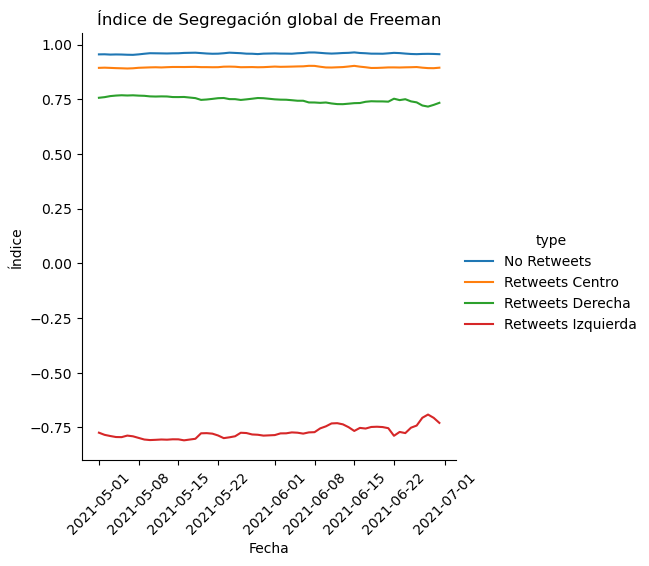

In [185]:
# Figure Mapping
sns.relplot(data = data_viz,
            x ='date',
            y = 'segregation_freeman',
            hue = 'type',
            kind = 'line')

# Labels
plt.title('Índice de Segregación global de Freeman')
plt.ylabel('Índice')
plt.xlabel('Fecha')
# Others
plt.xticks(rotation=45)
plt.show()

### 2. Spectral Segregation Index

In [9]:
# Load Adjacency matrices
files = glob('/mnt/disk2/Data/Matrices/3_Day_Window/*csr.npz')
data_viz = []

# This takes a While XD (runtime: 1 Hour aprox)
for file in files:
    #Loading the Adjacency Matrix as CRS
    data = np.load(file)
    indices = data['indices']
    indptr = data['indptr']
    shape = data['shape']
    data = data['data']
    adj = sp.csr_matrix((data, indices, indptr), shape = shape)

    #Getting the name of the Matrix
    adjacency_name = file.split('/')[-1].split('.')[0].split('_')[-1]

    data = Spectral_Segregation_Index(adj,types,user_indices)
    data['date'] = adjacency_name

    #Appending it to the data Visualization list
    data_viz.append(data)

# We create a Dataframe for Visualization
data_viz = pd.concat(data_viz)

# Transform the list to a big dataframe
data_viz['date'] = pd.to_datetime(data_viz['date'], format='%d-%m-%Y')

# Pivot to long format
data_viz = pd.melt(data_viz,
                    id_vars=['date'],
                    value_vars=['Dummy Derecha', 'Dummy Centro', 'No Retweets'], var_name='Group', value_name='segregation')

print("DataFrame in long format:")
data_viz.head()

/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divid

DataFrame in long format:


,date,Group,segregation
0,2021-05-26,Dummy Derecha,1.0
1,2021-06-03,Dummy Derecha,1.0
2,2021-05-05,Dummy Derecha,1.0
3,2021-05-09,Dummy Derecha,1.0
4,2021-06-24,Dummy Derecha,1.0


In [13]:
np.min(data_viz.segregation)

1.0

/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


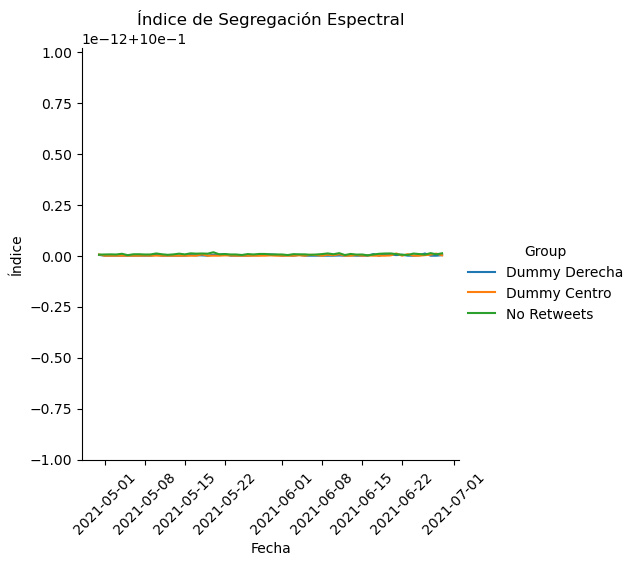

In [10]:
# Figure Mapping
sns.relplot(data = data_viz,
            x ='date',
            y = 'segregation',
            kind = 'line',
            hue = 'Group')

# Labels
plt.title('Índice de Segregación Espectral')
plt.ylabel('Índice')
plt.xlabel('Fecha')

# Others
plt.xticks(rotation=45)
plt.show()